In [1]:
import torch
import numpy as np
import logging
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from datasets import load_dataset
from tqdm import tqdm
import sys
import shap

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler('evaluation.log')
    ]
)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "facebook/wav2vec2-base-960h"

/home/hagen/SHAP-Transformer-ASR/.shaptransformerasr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-13 16:17:28.421891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
logger.info(f"Loading model: {model_name}")
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)
model = model.to(device)
logger.info("Model loaded successfully")

2025-09-13 16:17:34,750 - INFO - Loading model: facebook/wav2vec2-base-960h


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-09-13 16:18:26,270 - INFO - Model loaded successfully


In [20]:
def plot_spectrograms(S_original, S_amplified, sr):
    """
    Visualizes the original and amplified mel spectrograms side by side.
    """
    # Convert power spectrograms to decibels (dB) for better visualization
    S_db_original = librosa.power_to_db(S_original, ref=np.max)
    S_db_amplified = librosa.power_to_db(S_amplified, ref=np.max)

    # Create figure
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
    fig.suptitle('Mel Spectrogram Comparison', fontsize=16)

    # Plot original spectrogram
    img1 = librosa.display.specshow(S_db_original, sr=sr, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set(title='Original Spectrogram')
    ax[0].label_outer() # Hide x-axis label for the top plot
    fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')

    # Plot amplified spectrogram
    img2 = librosa.display.specshow(S_db_amplified, sr=sr, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Spectrogram with SHAP value amplification and clipping')
    fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

In [21]:
def plot_waveforms(y_original, y_modified, sr):
    """
    Visualizes the original and a modified audio waveform side by side.

    Args:
        y_original (np.ndarray): The original audio time series.
        y_modified (np.ndarray): The modified audio time series.
        sr (int): The sampling rate of the audio.
    """
    # Create a time array for the x-axis
    time_original = librosa.times_like(y_original, sr=sr)
    time_modified = librosa.times_like(y_modified, sr=sr)

    # Create a figure with two subplots, sharing the x and y axes
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8))
    fig.suptitle('Waveform Comparison', fontsize=16)

    # Plot the original waveform
    librosa.display.waveshow(y_original, sr=sr, ax=ax[0], color='b')
    ax[0].set(title='Original Waveform')
    ax[0].set_ylabel('Amplitude')
    ax[0].grid(True, linestyle='--', alpha=0.6)
    ax[0].label_outer() # Hide x-axis label for the top plot

    # Plot the modified waveform
    librosa.display.waveshow(y_modified, sr=sr, ax=ax[1], color='r')
    ax[1].set(title='Waveform with SHAP value amplification and clipping')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Amplitude')
    ax[1].grid(True, linestyle='--', alpha=0.6)

    # Add a legend to distinguish the waveforms
    fig.legend(['Original', 'Modified'], loc='upper right')
    
    # Adjust layout to prevent titles from overlapping and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

In [5]:
def normalize_and_scale_shap(shap_values, min_val=0.8, default=0.4):
    """
    Normalize SHAP values to [0, 1] and scale to [min_val, max_val].
    """
    # Normalize to [0, 1]
    shap_min = np.min(shap_values)
    shap_max = np.max(shap_values)
    normalized_shap = (shap_values - shap_min) / (shap_max - shap_min + 1e-8)  # Add small epsilon to avoid division by zero

    # Scale to [min_val, max_val]
    scaled_shap = ((normalized_shap-min_val).clip(0,1)/(1 - min_val)).clip(default, 1)
    return scaled_shap

In [13]:
audio = np.load("data/audio_sample_15_noisy_5.npy")
inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
input_values = inputs.input_values.to(device)

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)
logger.info(f"Transcription: {transcription}")
logger.info(f"Ouptut shape: {predicted_ids.shape}")

2025-09-13 16:27:43,491 - INFO - Transcription: ['ON THE GENERAL PRINCIPLES OF OURT WIT THEPOTER GREAT WI PEOPLE WO SEE TE BE']
2025-09-13 16:27:43,494 - INFO - Ouptut shape: torch.Size([1, 281])


In [14]:
shap_values = np.load("data/shap_values_sample_15_noisy_5.npy")
shap_values = shap_values.reshape(audio.shape[0], logits.shape[1])
logger.info(f"Loaded SHAP values with shape: {shap_values.shape}")
logger.info(f"Loaded audio with shape: {audio.shape}")

2025-09-13 16:27:47,271 - INFO - Loaded SHAP values with shape: (90240, 281)
2025-09-13 16:27:47,273 - INFO - Loaded audio with shape: (90240,)


In [15]:
predicted_ids

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  4,  4,  6, 11,
          5,  0,  4,  4, 21,  0,  0,  5,  0,  9,  0,  0,  5,  0, 13,  0,  7, 15,
         15,  0,  4,  4,  4,  0,  0,  0, 23,  0,  0, 13,  0, 10,  9,  0,  0, 19,
          0,  0,  0, 10,  0,  0, 23,  0,  0,  0, 15, 15,  5,  0,  0, 12, 12,  4,
          4,  0,  0,  8, 20,  0,  4,  0,  0,  0,  8, 16,  0, 13,  0,  6,  0,  0,
          4,  4,  4,  4,  0,  0,  0,  0, 18,  0,  0,  0, 10,  6,  0,  0,  4,  6,
         11,  5,  0,  0,  0,  0,  0, 23,  0,  0,  0,  0,  8,  0,  0,  0,  0,  6,
          0,  0,  0,  5,  0, 13, 13,  0,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,
         21,  0,  0, 13,  0,  0,  0,  5,  7,  0,  0,  6,  0,  0,  4,  4,  0,  0,
         18,  0,  0, 10,  0,  0,  0,  4,  0,  0,  0, 23,  5,  5,  0,  8,  0,  0,
          0, 23,  0,  0,  0, 15, 15,  5,  0,  4,  4,  0,  0,  0,  0, 18,  0,  0,
          0,  8,  0,  0,  0,

2025-09-13 16:31:12,062 - INFO - Character SHAP values shape before smoothing: [(90240,)]
2025-09-13 16:31:12,065 - INFO - Character SHAP values shape: [(90240,)]


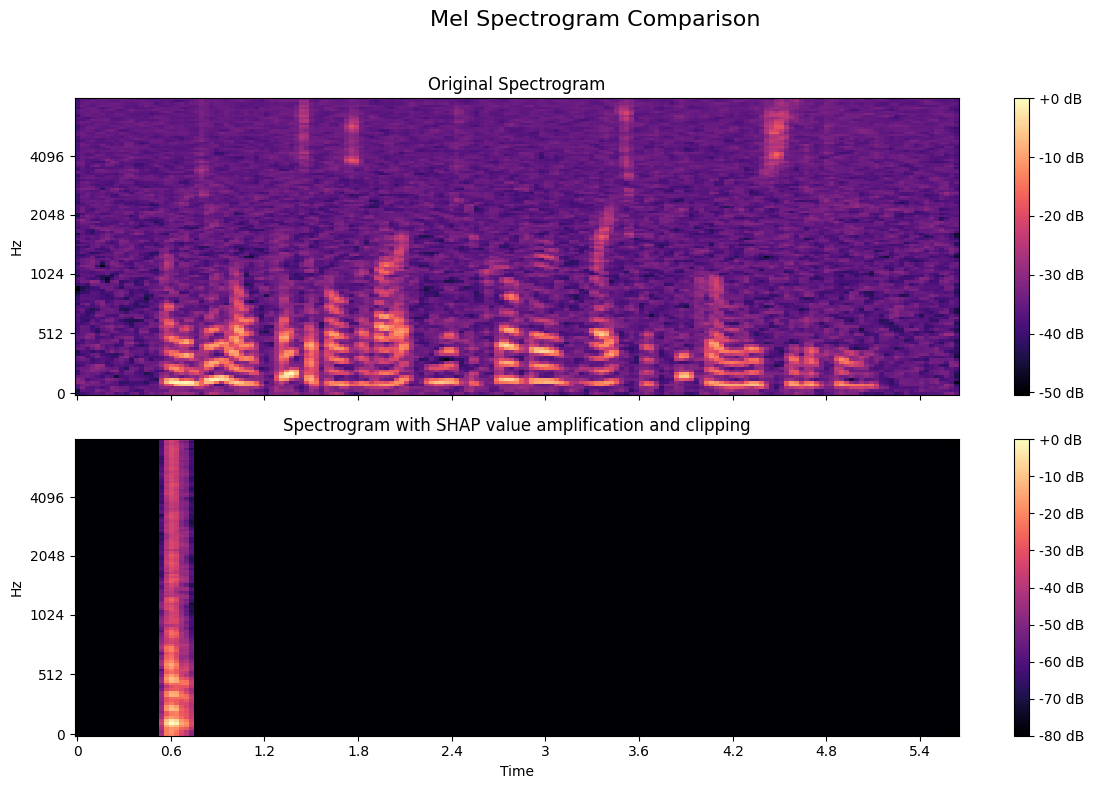

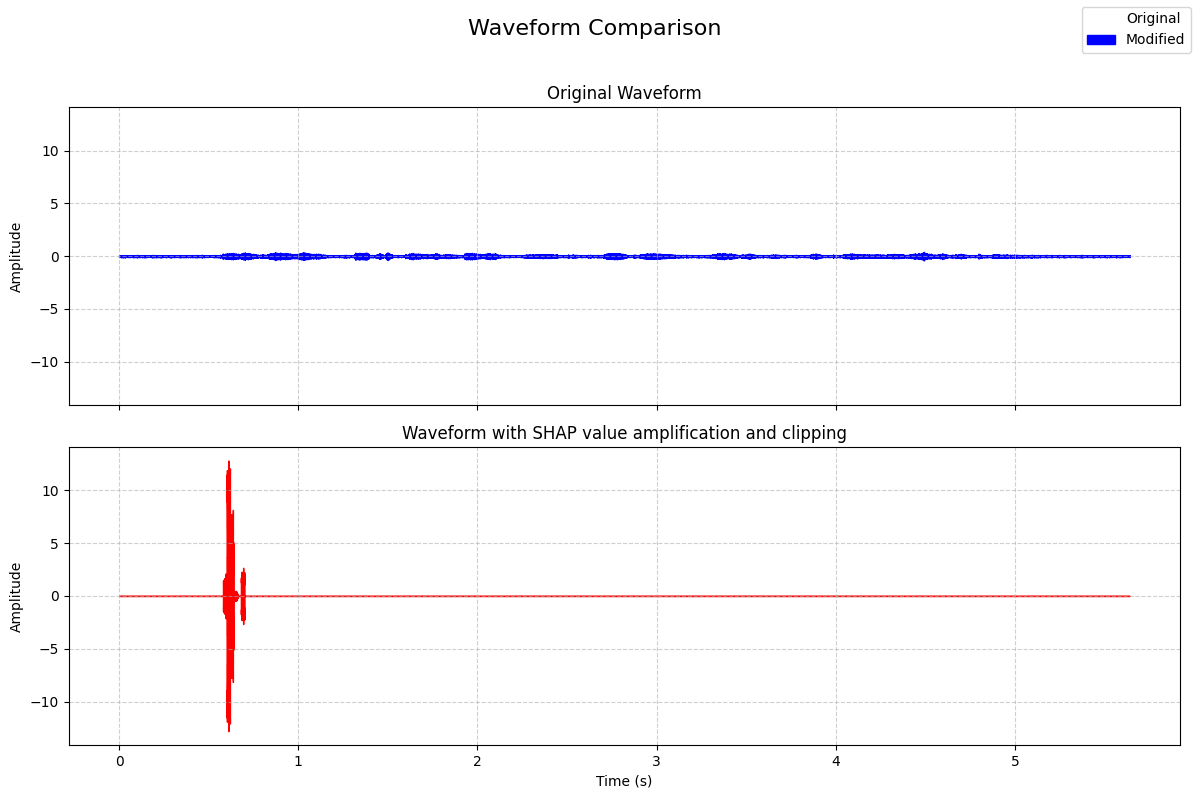

In [22]:
characters = [29]
character_shap_values = [np.zeros((audio.shape[0],)) for _ in characters]
for idx, char in enumerate(characters):
    for i, timestep in enumerate(shap_values):
        character_shap_values[idx][i] = abs(timestep[char])

window_length_ms = 20

num_of_frames = window_length_ms*16

logger.info(f"Character SHAP values shape before smoothing: {[vals.shape for vals in character_shap_values]}")

for arr in character_shap_values:
    for idx in range(0,len(arr),num_of_frames):
        mean = np.mean(arr[idx:min(idx+num_of_frames,len(arr))])
        arr[idx:min(idx+num_of_frames,len(arr))] = mean

logger.info(f"Character SHAP values shape: {[vals.shape for vals in character_shap_values]}")

character_norm_shap_values = [normalize_and_scale_shap(vals,0.80,0.0) for vals in character_shap_values]

#print(norm_m_shap_values.shape)

character_amplified_audio = [audio * vals for vals in character_norm_shap_values]

amplified_audio = sum(character_amplified_audio)/len(character_amplified_audio) * 10
S_amplified_audio = librosa.feature.melspectrogram(y=amplified_audio, sr=16000, n_fft=2048, hop_length=512)
S_audio = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=2048, hop_length=512)
sf.write("m_amplified_audio.wav", amplified_audio, 16000)
plot_spectrograms(S_audio, S_amplified_audio, sr=16000)
plot_waveforms(audio, amplified_audio*5, sr=16000)